## Dependencias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import sys
import scipy.stats as stats

sys.path.append('../')
import src.constants as c
from src.utils import read_pickle, save_to_pickle, save_information

## Lectura de info

In [2]:
X_train, y_train = read_pickle(c.train_data_v2)
X_test, y_test = read_pickle(c.test_data_v1)
transformer = read_pickle(c.transformer)
scaler = read_pickle(c.scaler)

## Modelos

In [3]:
alpha_grid = (
    list(np.linspace(0, 1, 101)[1:100]) + 
    list(np.arange(1,10, dtype=float)) + 
    list(np.arange(10, 55, 5))
)

model = Ridge()

param_grid = {
    'alpha' : alpha_grid
}

grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True, scoring="r2")

grid_search.fit(X_train, y_train)

orig_results = pd.DataFrame(grid_search.cv_results_)
mask = np.abs(orig_results["mean_train_score"] - orig_results["mean_test_score"]) < 0.01
results = orig_results[mask].sort_values("mean_test_score", ascending=False)
best_param = results.iloc[0]["params"]

## Graficas del r2

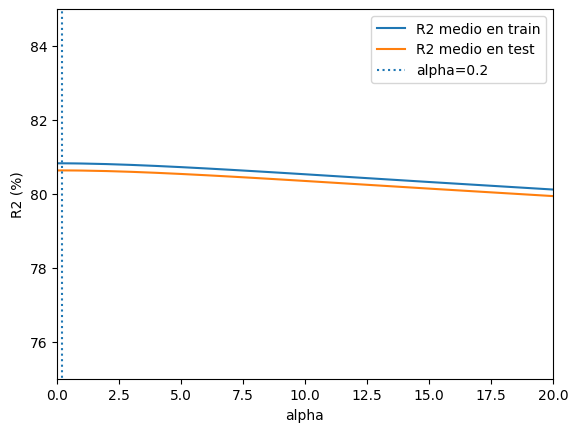

In [4]:
alpha = best_param.get("alpha")

## datos
x = orig_results["param_alpha"]
mean_train_r2 = orig_results["mean_train_score"]
mean_test_r2 = orig_results["mean_test_score"]

fig, ax = plt.subplots()
ax.plot(x, 100*mean_train_r2, label="R2 medio en train")
ax.plot(x, 100*mean_test_r2, label="R2 medio en test")
ax.vlines(alpha, 0, 100, linestyles ="dotted", label=f"alpha={alpha}")
ax.set(ylim=[75, 85], xlim=[0, 20], ylabel="R2 (%)", xlabel="alpha")
ax.legend()
plt.show()

## Modelo

In [5]:
best_model = Ridge(**best_param)

best_model.fit(X_train, y_train)

fitted_y = best_model.predict(X_train)
r2 = r2_score(y_train, fitted_y)

print(f"R2 del modelo en train: {r2*100:.2f}%")

R2 del modelo en train: 80.81%


## Graficas

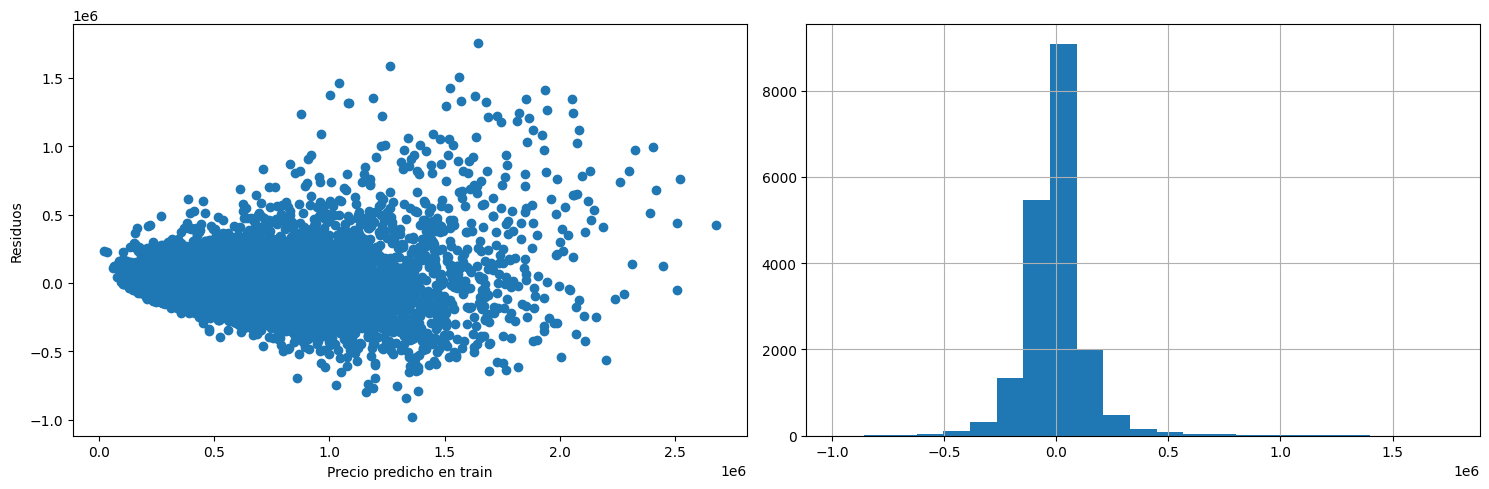

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
e = y_train - fitted_y
ax[0].scatter(fitted_y, e)
ax[0].set(xlabel="Precio predicho en train", ylabel="Residuos")

e = pd.Series(e)
e.hist(bins="doane", ax=ax[1])

plt.tight_layout()
plt.show()

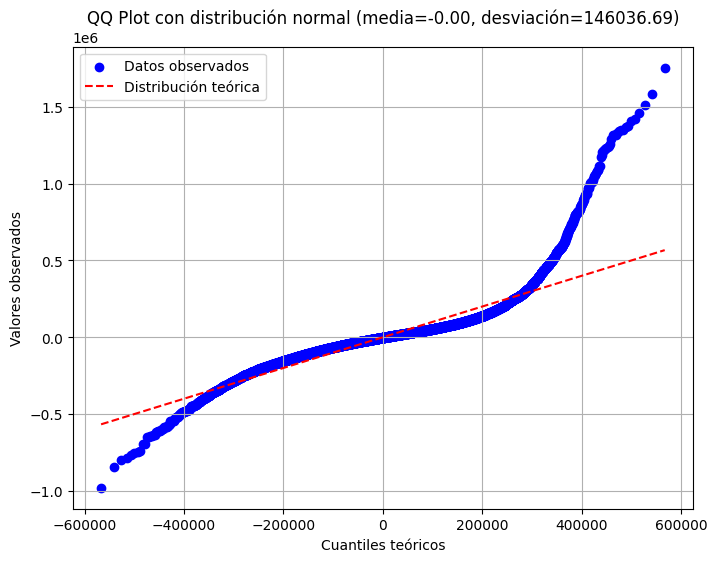

In [7]:
def generate_qq_plot(series, mean, std):
    """
    Genera un QQ plot comparando una serie de pandas con una distribución normal
    de media `mean` y desviación estándar `std`.

    Parámetros:
        series (pd.Series): La serie de datos.
        mean (float): Media de la distribución normal teórica.
        std (float): Desviación estándar de la distribución normal teórica.
    """
    # Generar los cuantiles teóricos de una distribución normal con media m y desviación estándar s
    theoretical_quantiles = np.linspace(0, 1, len(series) + 2)[1:-1]
    theoretical_quantiles = stats.norm.ppf(theoretical_quantiles, loc=mean, scale=std)

    # Ordenar los datos observados
    observed_values = np.sort(series)

    # Crear el QQ plot
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, observed_values, color='blue', label='Datos observados')
    plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--', label='Distribución teórica')

    plt.title(f'QQ Plot con distribución normal (media={mean:.2f}, desviación={std:.2f})')
    plt.xlabel('Cuantiles teóricos')
    plt.ylabel('Valores observados')
    plt.legend()
    plt.grid()
    plt.show()

generate_qq_plot(e, mean=e.mean(), std=e.std())

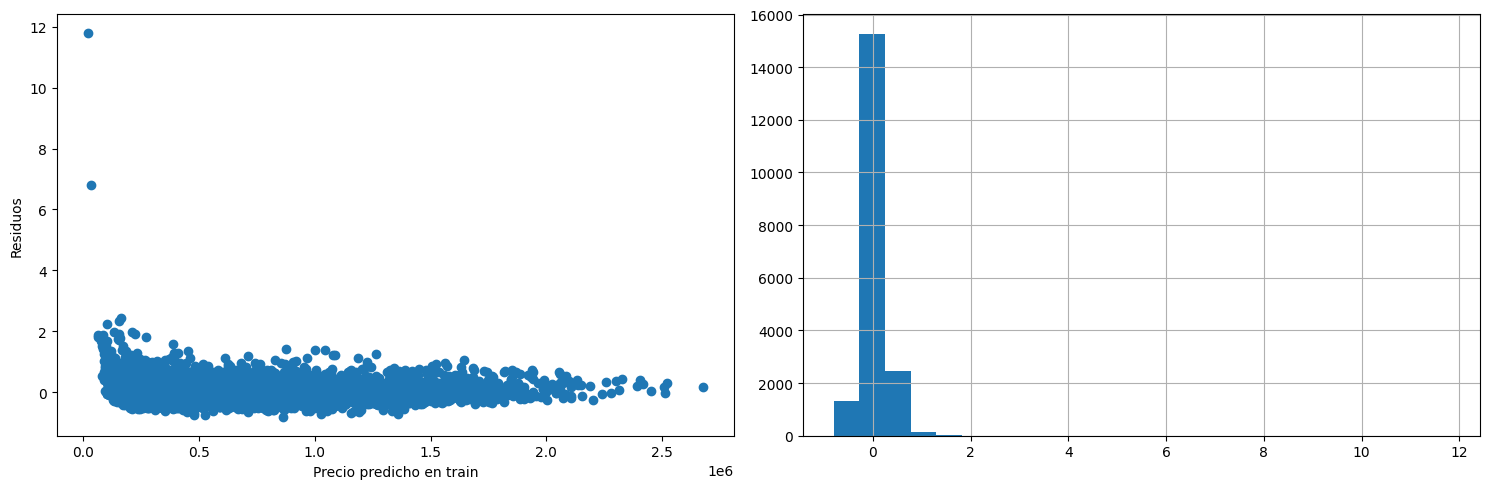

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
e_scaled = (y_train - fitted_y)/fitted_y
ax[0].scatter(fitted_y, e_scaled)
ax[0].set(xlabel="Precio predicho en train", ylabel="Residuos")
e_scaled = pd.Series(e_scaled)
e_scaled.hist(bins="doane", ax=ax[1])
plt.tight_layout()
plt.show()

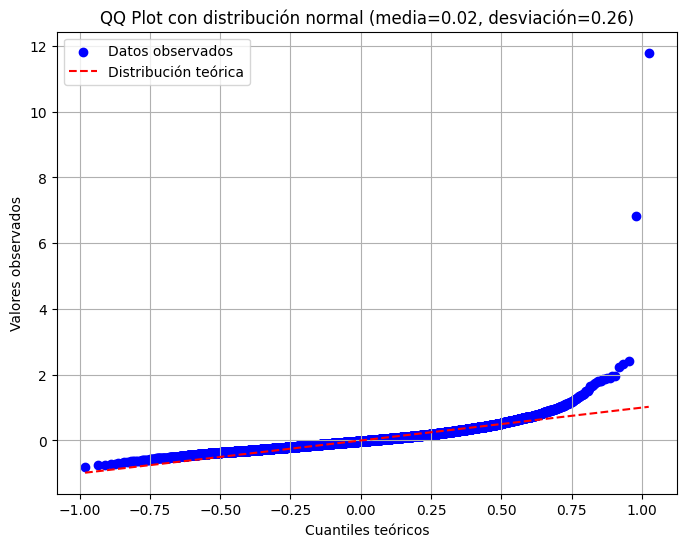

In [9]:
generate_qq_plot(e_scaled, mean=e_scaled.mean(), std=e_scaled.std())

## Performance en test

In [10]:
# transformando

X_test = transformer.transform(X_test)
cols = transformer.continous_variables
X_test[cols] = (
    pd.DataFrame(
        scaler.transform(X_test[cols]),
        columns=cols,
        index=X_test.index
    )
)

# prediciendo

y_predicted = best_model.predict(X_test)

r2 = r2_score(y_test, y_predicted)
print(f"R2 del modelo en test: {r2*100:.2f}%")

R2 del modelo en test: 78.70%
